In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

userList = np.load('../data/netflix/netflix_userList.npy')
itemList = np.load('../data/netflix/netflix_itemList.npy')

total_usr = len(userList)
total_item = len(itemList)

user_map = get_map(userList)
item_map = get_map(itemList)

In [3]:
df = pd.read_csv('../data/itri/rating_itri_pruned.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5
df_array = df.as_matrix()

userList = sorted(df['uid'].unique())
itemList = sorted(df['iid'].unique())

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

user_map = get_map(userList)
item_map = get_map(itemList)
    

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d, num. of ratings: %d" % (total_usr, total_item, len(df)))

sparsity of ratings is 5.16%
num. of users: 276, num. of items: 989, num. of ratings: 14072


# Clustering

In [22]:
user_vectors = np.load('../data/itri/user_vectors.npy')
pca = PCA(n_components=10, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
NUM_CLUSTER = 10
kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=10, algorithm='full')


kmeans.fit(pca_out)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
pca = PCA(n_components=2, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
colors = np.random.rand(len(pca_out[:, 0]))


plt.scatter(pca_out[:, 0], pca_out[:, 1], c=colors, alpha=0.5)
plt.savefig('figs/pca_scatter.jpg')
plt.gcf().clear()

In [24]:
label_map = {}
for i in kmeans.labels_:
    if i not in label_map:
        label_map[i] = 1
    else:
        label_map[i] += 1

print (label_map)

{9: 33, 8: 33, 1: 24, 6: 34, 5: 29, 3: 27, 2: 27, 0: 33, 4: 24, 7: 12}


In [25]:
label_index = {}
for i in range(NUM_CLUSTER):
    label_index[i] = []
    
label_list = list(kmeans.labels_)

for idx, i in enumerate(label_list):
    label_index[i].append(idx)

In [26]:
rating = np.zeros((total_usr, total_item), dtype=np.int8)
for line in df_array:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    rating[uid, iid] = 1

In [27]:
test_aps = []
test_rec = []

for i in range(NUM_CLUSTER):
    rating_n = np.take(rating, label_index[i], axis=0)
    train_user = label_index[i]
    train_rating, train_indices, test_indices = gen_train_test(rating_n)
    train_rating = np.take(rating, label_index[i], axis=0)
    train_indices = np.take(train_indices_all, label_index[i])
    test_indices = np.take(test_indices_all, label_index[i])
    
    tf.reset_default_graph()

    autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='log_loss',
                              batch_size=1, epochs=1000)
    autoencoder.model_load(0)
    autoencoder.train(rating=train_rating,
                      train_idents=train_user,
                      train_indices=train_indices,
                      test_indices=test_indices)
    
    """autoencoder.train(rating=rating,
                     train_idents=train_user)"""
    
    test_ap = autoencoder.log['ap@5']
    recs = autoencoder.log['recall@5']
    
    # top_N_ap = sorted(test_ap,reverse=True)[:20]
    # test_aps.append(np.mean(top_N_ap))
    
    test_aps.append(max(test_ap))
    test_rec.append(max(recs))
    
    plt.plot(range(len(test_ap)), test_ap, color='green', label='Test AP')
    # plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
    plt.legend(loc="upper right")
    plt.title("Train 200 epoch")
    plt.xlabel('#Epoch')
    plt.ylabel('AP')
    plt.savefig('./figs/test_ap_epoc_%d.jpg' % (i))
    plt.gcf().clear()
    

INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:25<00:00, 38.89it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:18<00:00, 53.56it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:24<00:00, 40.94it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:22<00:00, 44.11it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:19<00:00, 51.05it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:25<00:00, 39.83it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:27<00:00, 36.88it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:09<00:00, 106.37it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:26<00:00, 38.37it/s]


INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 1000/1000 [00:26<00:00, 37.40it/s]


In [28]:
ap = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap += test_aps[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps[i], num, test_aps[i]*num))
    
ap = ap / (total_usr)

print ("Over all average ap: %f" % (ap))

Cluster 0, aps: 0.393956, num: 33, weighted ap: 13.000556
Cluster 1, aps: 0.245706, num: 24, weighted ap: 5.896944
Cluster 2, aps: 0.434444, num: 27, weighted ap: 11.730000
Cluster 3, aps: 0.341152, num: 27, weighted ap: 9.211111
Cluster 4, aps: 0.359039, num: 24, weighted ap: 8.616944
Cluster 5, aps: 0.349885, num: 29, weighted ap: 10.146667
Cluster 6, aps: 0.436242, num: 34, weighted ap: 14.832222
Cluster 7, aps: 0.150556, num: 12, weighted ap: 1.806667
Cluster 8, aps: 0.310960, num: 33, weighted ap: 10.261667
Cluster 9, aps: 0.421313, num: 33, weighted ap: 13.903333
Over all average ap: 0.360167


In [29]:
recall_5 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    recall_5 += test_rec[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_rec[i], num, test_rec[i]*num))
    
recall_5 = recall_5 / (total_usr)

print ("Over all average ap: %f" % (recall_5))

Cluster 0, aps: 0.217657, num: 33, weighted ap: 7.182665
Cluster 1, aps: 0.199195, num: 24, weighted ap: 4.780686
Cluster 2, aps: 0.339598, num: 27, weighted ap: 9.169153
Cluster 3, aps: 0.180680, num: 27, weighted ap: 4.878361
Cluster 4, aps: 0.368366, num: 24, weighted ap: 8.840777
Cluster 5, aps: 0.294596, num: 29, weighted ap: 8.543290
Cluster 6, aps: 0.128321, num: 34, weighted ap: 4.362917
Cluster 7, aps: 0.170762, num: 12, weighted ap: 2.049145
Cluster 8, aps: 0.191322, num: 33, weighted ap: 6.313641
Cluster 9, aps: 0.133230, num: 33, weighted ap: 4.396592
Over all average ap: 0.219265


# Old

### For netflix huge dataset

user_train_rating = np.load('../data/netflix/rating_matrix_CDAE.npy')

train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

import pickle

np.save('../data/netflix/train_rating_all.npy', train_rating_all)

with open('../data/netflix/train_indices_all.pkl', 'wb') as train_indice_file:
    pickle.dump(train_indices_all, train_indice_file)
    
with open('../data/netflix/test_indices_all.pkl', 'wb') as test_indice_file:
    pickle.dump(test_indices_all, test_indice_file)

train_rating_all = np.load('../data/netflix/train_rating_all.npy')

import pickle

train_indices_all = None
test_indices_all = None

with open('../data/netflix/train_indices_all.pkl', 'rb') as train_indice_file:
    train_indices_all = pickle.load(train_indice_file)
    train_indice_file.close()
    
with open('../data/netflix/test_indices_all.pkl', 'rb') as test_indice_file:
    test_indices_all = pickle.load(test_indice_file)
    test_indice_file.close()

### For others

In [4]:
train_data = df.as_matrix()

user_train_rating = np.zeros((total_usr, total_item), dtype=np.int32)

for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1

## Build Model and Training

In [5]:
train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

tf.reset_default_graph()

train_user_all = np.nonzero(np.count_nonzero(train_rating_all, axis=1))[0]

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='log_loss',
                          batch_size=1, epochs=10000)


autoencoder.train(rating=train_rating_all,
                  train_idents=train_user_all,
                  train_indices=train_indices_all,
                  test_indices=test_indices_all)

autoencoder.model_save(0)

100%|██████████| 10000/10000 [35:45<00:00,  4.66it/s]


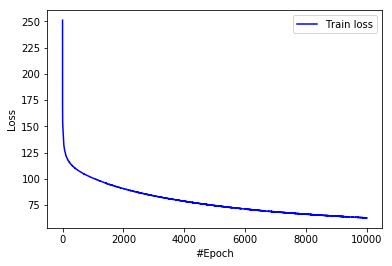

In [6]:
train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

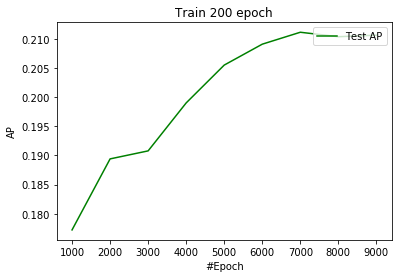

0.21113627214170705


In [16]:
test_ap = autoencoder.log['ap@5']

top_N_ap = sorted(test_ap,reverse=True)[:20]

plt.plot(range(1000, (len(test_ap)+1)*1000, 1000), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

# print (np.mean(top_N_ap))

print (max(test_ap))

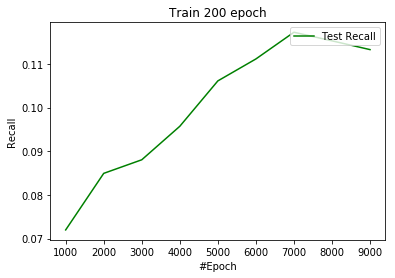

0.11724153660586499


In [18]:
test_recall = autoencoder.log['recall@5']

# top_N_ap = sorted(test_ap,reverse=True)[:20]

plt.plot(range(1000, (len(test_recall)+1)*1000, 1000), test_recall, color='green', label='Test Recall')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('Recall')
plt.show()

# print (np.mean(top_N_ap))

print (max(test_recall))

In [19]:
feature_vectors = np.zeros((total_usr, 20), dtype=np.float32)
for i in range(total_usr):
    feature_vectors[i] = autoencoder.sess.run(
        autoencoder.encode,
        feed_dict={
            autoencoder.input: [user_train_rating[i]]
        })
    
np.save('../data/itri/feature_vectors.npy', feature_vectors)

In [21]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)

np.save('../data/itri/user_vectors.npy', user_onehot_vectors)